In [202]:
from astrometry.util.fits import *
import pylab as plt
from collections import Counter
from astropy.table import Table
from astrometry.util.starutil_numpy import *
from scipy.optimize import brentq
from astrometry.util.util import radecdegtohealpix
from astrometry.util.util import *
from astrometry.util.miscutils import point_in_poly

In [219]:
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='serif')

In [1]:
T = fits_table('/global/cfs/cdirs/desi/users/raichoor/footprints/surveys-footprints-nside128.fits')

In [2]:
T.about()

tabledata object with 196608 rows and 55 columns:
   act_dr5 (<class 'numpy.ndarray'>) shape (196608,) dtype bool
   act_dr5_patchid (<class 'numpy.ndarray'>) shape (196608,) dtype >i8
   cfis_r (<class 'numpy.ndarray'>) shape (196608,) dtype bool
   cfis_r_patchid (<class 'numpy.ndarray'>) shape (196608,) dtype >i8
   cfis_u (<class 'numpy.ndarray'>) shape (196608,) dtype bool
   cfis_u_patchid (<class 'numpy.ndarray'>) shape (196608,) dtype >i8
   ctio_airmass (<class 'numpy.ndarray'>) shape (196608,) dtype >f8
   dec (<class 'numpy.ndarray'>) shape (196608,) dtype >f8
   des (<class 'numpy.ndarray'>) shape (196608,) dtype bool
   des_patchid (<class 'numpy.ndarray'>) shape (196608,) dtype >i8
   desi1b_bright (<class 'numpy.ndarray'>) shape (196608,) dtype bool
   desi1b_bright_patchid (<class 'numpy.ndarray'>) shape (196608,) dtype >i8
   desi1b_dark (<class 'numpy.ndarray'>) shape (196608,) dtype bool
   desi1b_dark_patchid (<class 'numpy.ndarray'>) shape (196608,) dtype >i8
   de

In [5]:
Counter(T.ibis_wide_patchid)

Counter({np.int64(-1): 171268, np.int64(1): 13757, np.int64(2): 11583})

In [17]:
def ra_display(ra):
    return ra + -360 * (ra > 276)

In [18]:
T.ra_display = ra_display(T.ra)

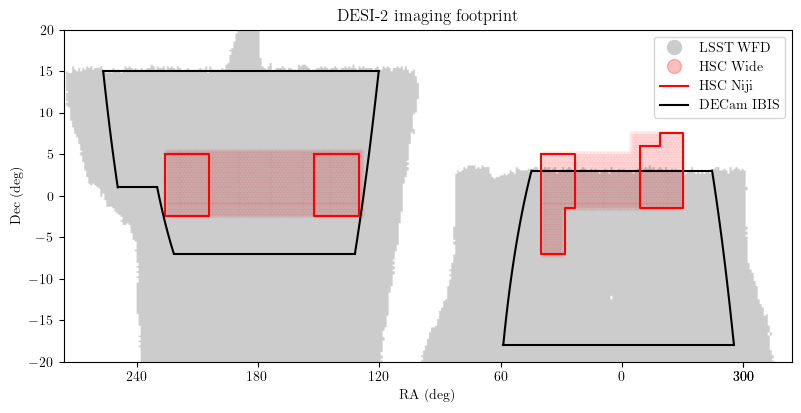

In [239]:
#plt.figure(figsize=(12,5))
plt.figure(figsize=(8,4))

plt.subplots_adjust(left=0.08, right=0.99, top=0.94, bottom=0.11)

ralo = -84.
rahi = 276.
declo = -20.
dechi = +20.

rr,dd = np.meshgrid(np.linspace(ralo, rahi, 361), np.linspace(declo, dechi, 201))
nside = 128
hp = np.array([healpix_xy_to_nested(radecdegtohealpix(r, d, nside), nside) for r,d in zip(rr.ravel(), dd.ravel())]).reshape(rr.shape)

I = np.flatnonzero(T.rubin_wfd)
hp_in_rubin = set(T.hpxpixel[I])
inrubin = np.array([h in hp_in_rubin for h in hp.ravel()]).reshape(hp.shape)
plt.imshow(1 - inrubin, extent=[ralo,rahi,declo,dechi], origin='lower', cmap='gray', vmin=-4, vmax=1, aspect='auto')
#plt.plot(T.ra_display[I], T.dec[I], '.', color='0.5', alpha=0.02, label='LSST WFD')

#I = np.flatnonzero(T.ibis_wide)
#plt.plot(T.ra_display[I], T.dec[I], '.', color='b', alpha=0.02, label='IBIS Wide')

I = np.flatnonzero(T.hsc_wide)
plt.plot(T.ra_display[I], T.dec[I], '.', color='r', alpha=0.02) #, label='HSC Wide')

p_lsst = plt.plot(-100, 0, '.', color='0.8', ms=20, label='LSST WFD')
p_hsc = plt.plot(-100, 0, '.', color='r', alpha=0.25, ms=20, label='HSC Wide')


# SGC (b < 0):
# -15 < dec < 6 AND ((b < -27 AND ra > 270) OR (b < -47 AND ra < 90))

sgc_dec_min = -18
sgc_dec_max =  +3
sgc_left_b = -27
sgc_right_b = -47

# left edge of SGC
# Find L range corresponding to B=-27, Dec=-18 and +3
l_min = brentq(lambda ell: galactictoradec(ell, sgc_left_b)[1] - sgc_dec_min, 0., 90.)
l_max = brentq(lambda ell: galactictoradec(ell, sgc_left_b)[1] - sgc_dec_max, 0., 90.)
ll = np.linspace(l_min, l_max, 50)
bb = np.zeros_like(ll) + sgc_left_b
r1,d1 = galactictoradec(ll, bb)
plt.plot(ra_display(r1), d1, 'k-')

# Right edge of SGC
l_min = brentq(lambda ell: galactictoradec(ell, sgc_right_b)[1] - sgc_dec_min, 150., 250.)
l_max = brentq(lambda ell: galactictoradec(ell, sgc_right_b)[1] - sgc_dec_max, 150., 250.)
ll = np.linspace(l_min, l_max, 50)
bb = np.zeros_like(ll) + sgc_right_b
r2,d2 = galactictoradec(ll, bb)
plt.plot(ra_display(r2), d2, 'k-')

# bottom of SGC
plt.plot(ra_display(np.array([min(r1), max(r2)])), [sgc_dec_min]*2, 'k-')
# top of SGC
plt.plot(ra_display(np.array([max(r1), min(r2)])), [sgc_dec_max]*2, 'k-')

# -7 < dec < 15 AND ((b > 22 AND ra <= 180) OR (b > 30 AND ra >= 180 AND dec > 1) OR (b > 46 AND ra >= 180 AND dec > -10))

# polygon
ibis_sgc = [
    (r1,d1),
    ([max(r1), min(r2)], [sgc_dec_max]*2),
    (r2[::-1],d2[::-1]),
    ([max(r2), min(r1)], [sgc_dec_min]*2),
]

# NGC (b > 0):
# -7 < dec < 15 AND ((b > 22 AND ra <= 180) OR (b > 30 AND ra >= 180 AND dec > 1) OR (b > 46 AND ra >= 180 AND dec > -10))

# "Left" and "Right" here were when I was looking at a plot with RA not flipped!!
ngc_left_b = +22
ngc_left_dec_min = -7
ngc_left_dec_max = 15

ngc_right1_b = +30
ngc_right1_dec_min = 1
ngc_right1_dec_max = 15

ngc_right2_b = +46
ngc_right2_dec_max = 1
ngc_right2_dec_min = -7

# Left edge of NGC
l_min = brentq(lambda ell: galactictoradec(ell, ngc_left_b)[1] - ngc_left_dec_min, 180., 270.)
l_max = brentq(lambda ell: galactictoradec(ell, ngc_left_b)[1] - ngc_left_dec_max, 180., 270.)
ll = np.linspace(l_min, l_max, 50)
bb = np.zeros_like(ll) + ngc_left_b
r3,d3 = galactictoradec(ll, bb)
plt.plot(ra_display(r3), d3, 'k-')

# Far right edge of NGC
l_min = brentq(lambda ell: galactictoradec(ell, ngc_right1_b)[1] - ngc_right1_dec_min, 0., 90.)
l_max = brentq(lambda ell: galactictoradec(ell, ngc_right1_b)[1] - ngc_right1_dec_max, 0., 90.)
ll = np.linspace(l_min, l_max, 50)
bb = np.zeros_like(ll) + ngc_right1_b
r4,d4 = galactictoradec(ll, bb)
plt.plot(ra_display(r4), d4, 'k-')

# Near right edge of NGC
l_min = brentq(lambda ell: galactictoradec(ell, ngc_right2_b)[1] - ngc_right2_dec_min, 300., 380.)
l_max = brentq(lambda ell: galactictoradec(ell, ngc_right2_b)[1] - ngc_right2_dec_max, 300., 380.)
ll = np.linspace(l_min, l_max, 50)
bb = np.zeros_like(ll) + ngc_right2_b
r5,d5 = galactictoradec(ll, bb)
ibis_rd = [(r1,d1),(r2,d2),(r3,d3),(r4,d4),(r5,d5)]

# top of NGC
plt.plot(ra_display(np.array([min(r3), max(r4)])), [ngc_left_dec_max]*2, 'k-')
# left-bottom of NGC
plt.plot(ra_display(np.array([max(r3), min(r5)])), [ngc_left_dec_min]*2, 'k-')
# right-bottom of NGC
plt.plot(ra_display(np.array([max(r5), min(r4)])), [ngc_right1_dec_min]*2, 'k-')

# polygon
ibis_ngc = [
    (r3, d3),
    (np.array([min(r3), max(r4)]), [ngc_left_dec_max]*2),
    (r4[::-1],d4[::-1]),
    (np.array([min(r4), max(r5)]), [ngc_right1_dec_min]*2),
    (r5[::-1],d5[::-1]),
    (np.array([min(r5), max(r3)]), [ngc_left_dec_min]*2),
]

#ll = np.linspace(300., 360., 50)
#bb = np.zeros_like(ll) + ngc_right2_b
#r,d = galactictoradec(ll, bb)
#plt.scatter(ra_display(r), d, c=ll, zorder=20)
#plt.colorbar()

# HSC-Niji - WIDE field 1
r1,r2,r3 = 40, 28, 23
d1,d2,d3 = -7, -1.5, +5
rr1 = np.array([r1, r3, r3, r2, r2, r1, r1])
dd1 = np.array([d3, d3, d2, d2, d1, d1, d3])
# area:
area1 = np.abs((r2-r1)*(np.rad2deg(np.sin(np.deg2rad(d3))-np.sin(np.deg2rad(d1)))) +
               (r3-r2)*(np.rad2deg(np.sin(np.deg2rad(d3))-np.sin(np.deg2rad(d2)))))

# HSC-Niji - WIDE field 2
r1,r2,r3 = -9, -19, -30
d1,d2,d3 = -1.5, 6, 7.5
rr2 = np.array([r1, r2, r2, r3, r3, r1, r1])
dd2 = np.array([d2, d2, d3, d3, d1, d1, d2])
# area:
area2 = np.abs((r2-r1)*(np.rad2deg(np.sin(np.deg2rad(d2))-np.sin(np.deg2rad(d1)))) +
               (r3-r2)*(np.rad2deg(np.sin(np.deg2rad(d3))-np.sin(np.deg2rad(d1)))))

# HSC-Niji - WIDE field 3
r1,r2 = 226, 204
d1,d2 = -2.5, +5
rr3 = np.array([r1, r2, r2, r1, r1])
dd3 = np.array([d2, d2, d1, d1, d2])
# area:
area3 = np.abs((r1-r2)*(np.rad2deg(np.sin(np.deg2rad(d2))-np.sin(np.deg2rad(d1)))))

# HSC-Niji - WIDE field 4
r1,r2 = 152,130
d1,d2 = -2.5, +5
rr4 = np.array([r1, r2, r2, r1, r1])
dd4 = np.array([d2, d2, d1, d1, d2])
# area:
area4 = np.abs((r1-r2)*(np.rad2deg(np.sin(np.deg2rad(d2))-np.sin(np.deg2rad(d1)))))

niji_polys = [(rr1,dd1), (rr2,dd2), (rr3,dd3), (rr4,dd4)]

plt.plot(rr1, dd1, 'r-')
plt.plot(rr2, dd2, 'r-')
plt.plot(rr3, dd3, 'r-')
plt.plot(rr4, dd4, 'r-', label='HSC Niji')

r5,d5 = ibis_rd[-1]
plt.plot(ra_display(r5), d5, 'k-', label='DECam IBIS')

plt.legend()

xt = [300, 0, 60, 120, 180, 240, 300]
plt.xticks(ra_display(np.array(xt)), xt)
plt.ylim(declo, dechi)
plt.xlim(rahi, ralo);
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)');
plt.title('DESI-2 imaging footprint')
plt.savefig('footprint.pdf')
plt.savefig('footprint.png')

In [196]:
area1, area2, area3, area4

(np.float64(176.18248737868026),
 np.float64(173.65139890363133),
 np.float64(164.84298645647286),
 np.float64(164.84298645647286))

In [258]:
area1 + area2 + area3 + area4

np.float64(679.5198591952574)

In [208]:
poly_ngc = np.vstack((ra_display(np.hstack([r for r,d in ibis_ngc])), np.hstack([d for r,d in ibis_ngc])))
poly_sgc = np.vstack((ra_display(np.hstack([r for r,d in ibis_sgc])), np.hstack([d for r,d in ibis_sgc])))

In [225]:
poly_ngc.shape

(2, 156)

In [247]:
T.ibis_wide_bounds = np.zeros(len(T), bool)
for poly in [poly_ngc, poly_sgc]:
    T.ibis_wide_bounds |= point_in_poly(T.ra_display, T.dec, poly.T)

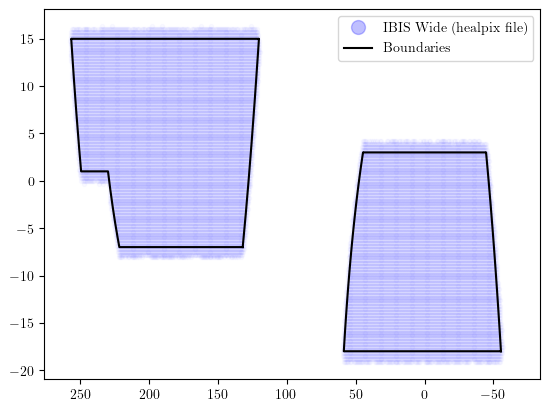

In [236]:
I = np.flatnonzero(T.ibis_wide)
in_ngc = point_in_poly(T.ra_display[I], T.dec[I], poly_ngc.T)
in_sgc = point_in_poly(T.ra_display[I], T.dec[I], poly_sgc.T)
plt.plot(T.ra_display[I], T.dec[I], '.', color='b', alpha=0.02)#, label='IBIS Wide')
plt.plot(-100, 0, '.', color='b', alpha=0.25, ms=20, label='IBIS Wide (healpix file)')
n3 = len(I)
J = I[in_ngc]
#plt.plot(T.ra_display[J], T.dec[J], '.')
n1 = len(J)
J = I[in_sgc]
#plt.plot(T.ra_display[J], T.dec[J], '.')
n2 = len(J)
plt.plot(poly_ngc[0,:], poly_ngc[1,:], 'k-')
plt.plot(poly_sgc[0,:], poly_sgc[1,:], 'k-', label='Boundaries');
plt.legend()
plt.xlim(276, -84)
plt.savefig('ibis-bounds.png')

In [213]:
(n1+n2) / (12*nside**2) * 4 * np.pi * np.rad2deg(1.)**2

np.float64(4705.7096452877095)

In [230]:
(n3) / (12*nside**2) * 4 * np.pi * np.rad2deg(1.)**2

np.float64(5316.925242412742)

In [253]:
T.hsc_niji = np.zeros(len(T), bool)
for r,d in niji_polys:
    poly = np.vstack((r,d)).T
    in_poly = point_in_poly(T.ra_display, T.dec, poly)
    T.hsc_niji |= in_poly

I = np.flatnonzero(T.hsc_niji)
#plt.plot(T.ra_display[I], T.dec[I], '.')
n4 = len(I);

In [254]:
(n4) / (12*nside**2) * 4 * np.pi * np.rad2deg(1.)**2

np.float64(682.5555569679814)

In [255]:
I = np.flatnonzero(T.ibis_wide_bounds)
n5 = len(I)
a5 = (n5) / (12*nside**2) * 4 * np.pi * np.rad2deg(1.)**2
a5

np.float64(4705.7096452877095)

In [256]:
I = np.flatnonzero(T.ibis_wide_bounds * ~T.hsc_niji)
n6 = len(I)
a6 = (n6) / (12*nside**2) * 4 * np.pi * np.rad2deg(1.)**2
a6

np.float64(4132.472085608482)

In [257]:
a5 - a6

np.float64(573.2375596792272)

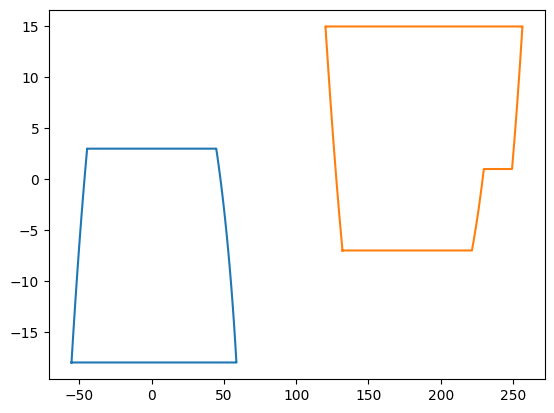

In [200]:
plt.plot(ra_display(np.hstack([r for r,d in ibis_sgc])), np.hstack([d for r,d in ibis_sgc]), '-')
plt.plot(ra_display(np.hstack([r for r,d in ibis_ngc])), np.hstack([d for r,d in ibis_ngc]), '-')

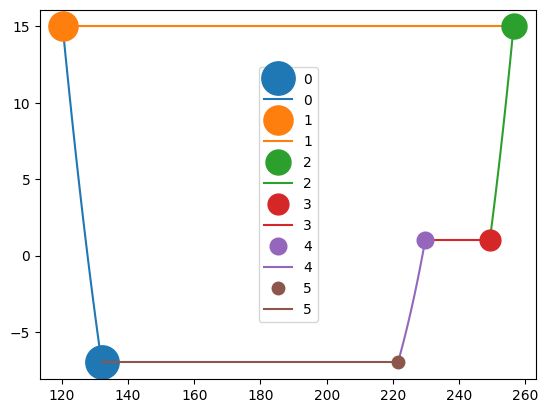

In [201]:
for i,(r,d) in enumerate(ibis_ngc):
    p = plt.plot(r[0], d[0], 'o', label='%i'%i, ms=(8-i)*3)
    plt.plot(r, d, '-', label='%i'%i, color=p[0].get_color())
    plt.legend()

In [14]:
IBIS = Table.read('ibis-observing/obstatus/ibis-tiles.ecsv')

In [15]:

IBIS

OBJECT,TILEID,RA,DEC,FILTER,DESIGNHA,PRIORITY,PASS,IN_IBIS,EBV_MED,EFFTIME_TOT,DONE,EFFTIME_GOAL
str25,int32,float64,float64,str4,float64,float64,int16,int16,float32,float32,int16,float32
IBIS_deep_xmm_M411_1,1,35.751,-4.25,M411,0.0,3.0,0,1,0.024897,208.83,1,458.97
IBIS_deep_xmm_M411_2,2,35.438,-4.225,M411,0.0,3.0,0,1,0.023187,275.73,1,452.81
IBIS_deep_xmm_M411_3,3,35.156,-4.368,M411,0.0,3.0,0,1,0.022136,201.7,1,449.07
IBIS_deep_xmm_M411_4,4,34.969,-4.622,M411,0.0,3.0,0,1,0.021648,296.88,1,447.34
IBIS_deep_xmm_M411_5,5,34.901,-4.931,M411,0.0,3.0,0,1,0.021954,369.33,1,448.42
IBIS_deep_xmm_M411_6,6,34.952,-5.243,M411,0.0,3.0,0,1,0.022813,238.93,1,451.48
IBIS_deep_xmm_M411_7,7,35.107,-5.52,M411,0.0,3.0,0,1,0.023991,265.57,1,455.7
IBIS_deep_xmm_M411_8,8,35.343,-5.733,M411,0.0,3.0,0,1,0.024943,235.0,1,459.14
IBIS_deep_xmm_M411_9,9,35.632,-5.866,M411,0.0,3.0,0,1,0.025645,324.33,1,461.69


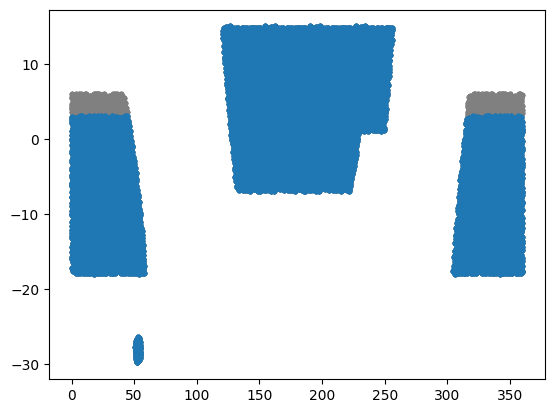

In [19]:
plt.plot(IBIS['RA'], IBIS['DEC'], '.', color='0.5')
I = np.flatnonzero(IBIS['IN_IBIS'])
plt.plot(IBIS['RA'][I], IBIS['DEC'][I], '.')
